In [281]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

Data dictionary:

    Index: Row index
    user id: User ID (unique)
    test group: If "ad" the person saw the advertisement, if "psa" they only saw the public service announcement
    converted: If a person bought the product then True, else is False
    total ads: Amount of ads seen by person
    most ads day: Day that the person saw the biggest amount of ads
    most ads hour: Hour of day that the person saw the biggest amount of ads



Откроем данные и проведем разведку.

In [171]:
df = pd.read_csv('marketing_AB.csv', index_col=0)

In [182]:
df.head()

,user id,test group,converted,total ads,most ads day,most ads hour,total ads bucket
0,1069124,ad,False,130,Monday,20,"(100, 150]"
1,1119715,ad,False,93,Tuesday,22,"(50, 100]"
2,1144181,ad,False,21,Tuesday,18,"(0, 50]"
3,1435133,ad,False,355,Tuesday,10,"(300, 10000]"
4,1015700,ad,False,276,Friday,14,"(250, 300]"


In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   user id           588101 non-null  int64   
 1   test group        588101 non-null  object  
 2   converted         588101 non-null  bool    
 3   total ads         588101 non-null  int64   
 4   most ads day      588101 non-null  object  
 5   most ads hour     588101 non-null  int64   
 6   total ads bucket  588101 non-null  category
dtypes: bool(1), category(1), int64(3), object(2)
memory usage: 28.0+ MB


In [184]:
df.nunique()

user id             588101
test group               2
converted                2
total ads              807
most ads day             7
most ads hour           24
total ads bucket         7
dtype: int64

Здесь я хочу посмотреть разные зависимтости конверсии в покупку от разных факторов. Сначала от количества увиденных пользователем реклам. Так как разброс увиденных реклам слишком большой (807), я решил разбить пользователей на бакеты с шагом в 50. 

In [185]:
df['total ads bucket'] = pd.cut(df['total ads'], [0, 50, 100, 150, 200, 250, 300, 10000])

In [186]:
df.head()

,user id,test group,converted,total ads,most ads day,most ads hour,total ads bucket
0,1069124,ad,False,130,Monday,20,"(100, 150]"
1,1119715,ad,False,93,Tuesday,22,"(50, 100]"
2,1144181,ad,False,21,Tuesday,18,"(0, 50]"
3,1435133,ad,False,355,Tuesday,10,"(300, 10000]"
4,1015700,ad,False,276,Friday,14,"(250, 300]"


Заранее разбиваю пользователей на тестовых и контрольных, чтобы было проще работать с ними.

In [187]:
control = df[df['test group'] == 'psa']
test = df[df['test group'] == 'ad']

In [188]:
test.head()

,user id,test group,converted,total ads,most ads day,most ads hour,total ads bucket
0,1069124,ad,False,130,Monday,20,"(100, 150]"
1,1119715,ad,False,93,Tuesday,22,"(50, 100]"
2,1144181,ad,False,21,Tuesday,18,"(0, 50]"
3,1435133,ad,False,355,Tuesday,10,"(300, 10000]"
4,1015700,ad,False,276,Friday,14,"(250, 300]"


In [189]:
control.head()

,user id,test group,converted,total ads,most ads day,most ads hour,total ads bucket
18,900681,psa,False,248,Saturday,19,"(200, 250]"
38,905704,psa,False,27,Thursday,8,"(0, 50]"
68,904595,psa,False,13,Tuesday,19,"(0, 50]"
140,901904,psa,False,32,Wednesday,19,"(0, 50]"
157,902234,psa,False,105,Tuesday,19,"(100, 150]"


Далее считаю конверсии в покупку для каждого бакета отдельно по тестовой выборке и контрольной.

In [196]:
converts_test = test \
    .groupby(['total ads bucket', 'converted']) \
    .agg({'converted': 'count'}) \
    .rename(columns={'converted': 'count'}) \
    .reset_index()

totals_test = test.groupby('total ads bucket')['converted'].count()

conversion_test = converts_test.merge(totals_test, on='total ads bucket') \
    .rename(columns={'converted_y': 'total', 'converted_x': 'converted'})

conversion_test['ratio'] = conversion_test['count'] / conversion_test['total']

In [198]:
conversion_test

,total ads bucket,converted,count,total,ratio
0,"(0, 50]",False,492865,498374,0.988946
1,"(0, 50]",True,5509,498374,0.011054
2,"(50, 100]",False,39014,44149,0.883689
3,"(50, 100]",True,5135,44149,0.116311
4,"(100, 150]",False,9731,11854,0.820904
5,"(100, 150]",True,2123,11854,0.179096
6,"(150, 200]",False,3737,4506,0.829339
7,"(150, 200]",True,769,4506,0.170661
8,"(200, 250]",False,1891,2224,0.850270
9,"(200, 250]",True,333,2224,0.149730


In [201]:
converts_control = control \
    .groupby(['total ads bucket', 'converted']) \
    .agg({'converted': 'count'}) \
    .rename(columns={'converted': 'count'}) \
    .reset_index()

totals_control = control.groupby('total ads bucket')['converted'].count()

conversion_control = converts_control.merge(totals_control, on='total ads bucket') \
    .rename(columns={'converted_y': 'total', 'converted_x': 'converted'})

conversion_control['ratio'] = conversion_control['count'] / conversion_control['total']

In [203]:
conversion_control

,total ads bucket,converted,count,total,ratio
0,"(0, 50]",False,20468,20661,0.990659
1,"(0, 50]",True,193,20661,0.009341
2,"(50, 100]",False,1746,1853,0.942256
3,"(50, 100]",True,107,1853,0.057744
4,"(100, 150]",False,476,533,0.893058
5,"(100, 150]",True,57,533,0.106942
6,"(150, 200]",False,196,219,0.894977
7,"(150, 200]",True,23,219,0.105023
8,"(200, 250]",False,95,112,0.848214
9,"(200, 250]",True,17,112,0.151786


И теперь для наглядности построю график конверсий для обеих выборок.

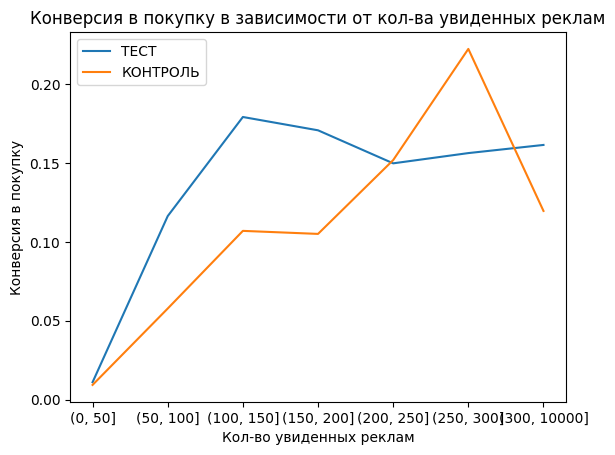

In [250]:
plt.plot(conversion_test[conversion_test['converted'] == True]['total ads bucket'], 
         conversion_test[conversion_test['converted'] == True]['ratio'], 
         label='ТЕСТ')
         
plt.plot(conversion_control[conversion_control['converted'] == True]['total ads bucket'], 
         conversion_control[conversion_control['converted'] == True]['ratio'], 
         label='КОНТРОЛЬ')

plt.title('Конверсия в покупку в зависимости от кол-ва увиденных реклам')
plt.xlabel('Кол-во увиденных реклам')
plt.ylabel('Конверсия в покупку')
plt.legend()
plt.show()

Вроде как прослеживается тенденция: чем больше реклам увидел пользователь, тем с большей вероятностью он совершает покупку. Интересное наблюдение, что у 300+ увиденных реклам юзеров начинается просадка в конверсии, однако по таблице выше видно, что таких пользователей просто слишком мало (11), поэтому лучше не строить по них выводов.

А в целом ощущается, что у тестовой выборки конверсия выглядит посолиднее, это мы еще позже проверим с помощью теста.

Далее можно посмотреть в какие дни и/или часы пользователь видел больше всего реклам, однако такая метрика кажется мне довольно комлексной, т. е. не исключает влияния других факторов на нее, которые мы не сможем отследить по имеющимся данным, поэтому просто поверхносто взглядем на эти распределения и проверим на наличие аномалий.

In [265]:
df \
    .groupby(['test group', 'most ads day']) \
    .agg({'user id': 'count'}) \
    .sort_values(by=['test group', 'user id'], ascending=False)

user id
test group most ads day         
psa        Thursday         3905
           Friday           3803
           Monday           3502
           Wednesday        3490
           Sunday           3059
           Tuesday          2907
           Saturday         2858
ad         Friday          88805
           Monday          83571
           Sunday          82332
           Thursday        79077
           Saturday        78802
           Wednesday       77418
           Tuesday         74572

In [266]:
df \
    .groupby(['test group', 'most ads hour']) \
    .agg({'user id': 'count'}) \
    .sort_values(by=['test group', 'user id'], ascending=False)

user id
test group most ads hour         
psa        13                2170
           11                2061
           12                2060
           14                1869
           15                1828
           16                1604
           10                1485
           17                1383
           18                1271
           9                 1202
           19                1183
           21                1081
           20                1077
           22                 917
           8                  659
           23                 619
           7                  237
           0                  227
           1                  187
           2                  181
           3                   89
           6                   83
           4                   28
           5                   23
ad         13               45485
           12               45238
           11               44149
           14               43779
           15               42855
           10               37454
           16               35963
           17               33605
           18               31052
           9                29802
           19               29169
           21               28895
           20               27846
           22               25515
           23               19547
           8                16968
           7                 6168
           0                 5309
           2                 5152
           1                 4615
           3                 2590
           6                 1985
           5                  742
           4                  694

Вроде ничего необычного - больше всего просмотров реклам в обед и вечером, по ночам люди преимущественно спят. Пятница и понедельник ожидаемо самые топовые дни (в понедельник трудно сконцентрироваться на работе видимо, а в пятницу уже довольно лень работать). А может и не так :). В любом случае, в эти дни люди обычно чаще залипают в телефоны.

Итак, изучим разность средних в наших выборках на стат значимость.

In [298]:
test['converted'].mean().round(4), control['converted'].mean().round(4)

(0.0255, 0.0179)

In [287]:
s = [len(df[(df['test group'] == 'ad') & (df['converted'] == True)]),
     len(df[(df['test group'] == 'psa') & (df['converted'] == True)])]

n = [len(df[df['test group'] == 'ad']),
    len(df[df['test group'] == 'psa'])]

z_stat, pval = proportions_ztest(s, n, alternative='larger')
pval

8.526403580779863e-14

p-value настолько ничтожно мал, что какой уровень значимости альфа ни возьми, все равно эти выборки буду статистически значимо отличаться друг от друга.

АБ-тест определенно получился зеленым (конечно, если он был верно задизайнен), и я бы рекомендовал раскатывать рекламу на всех пользователей.